In [1]:
import mglearn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
from matplotlib import pyplot as plt
from matplotlib import font_manager, rc 
import matplotlib.font_manager as fm
import seaborn as sns

for font_path in fm.findSystemFonts(fontpaths = None, fontext = 'ttf'):
    if 'D2Coding' in font_path:
        font = font_manager.FontProperties(fname=font_path).get_name()
        rc('font', family=font)
        break 

In [3]:
SEED = 42

# 차원의 저주(The curse of dimensionality)

- 데이터 학습을 위해 차원(feature)이 증가하면서 학습 데이터 수가 차원의 수보다 적어져 성능이 저하되는 현상
- 차원이 증가할수록 개별 차원 내 학습할 데이터 수가 적어지는(sparse) 현상 발생
- 예) nunique 값이 높은 column에 one-hot encoding을 실행하는 경우

해당 현상이 발생할 경우 차원을 축소하거나 더 많은 데이터를 수집할 필요가 있음.

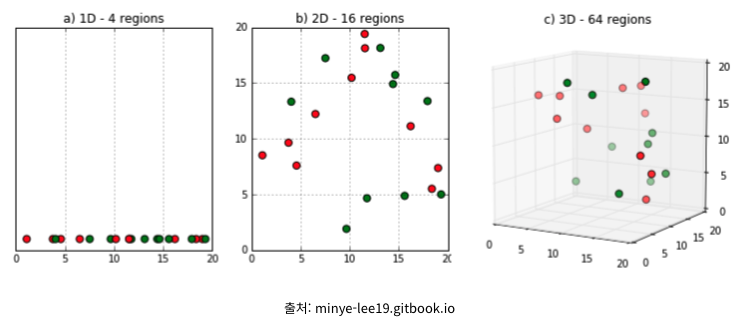

데이터의 양이 동일한 상태에서 차원만 늘어나면 빈 공간이 많아진다.  
따라서 모델이 학습할 때 상대적으로 데이터가 적어지므로, 성능이 저하될 수밖에 없다.  

특히 KNN과 같은 알고리즘은 성능 저하가 매우 심해진다.

## KNN을 이용한 예제

In [4]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.preprocessing import OneHotEncoder

In [6]:
X, y = mglearn.datasets.make_forge()
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=SEED)

c:\Users\workspace\lectures\git_practice\data_engineering\practices\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


In [7]:
clf = KNeighborsClassifier(n_neighbors=3).fit(X_tr, y_tr)
print(f'훈련용 평가지표: {clf.score(X_tr, y_tr)} / 테스트용 평가지표: {clf.score(X_te, y_te)}')

훈련용 평가지표: 0.9473684210526315 / 테스트용 평가지표: 0.8571428571428571


In [8]:
print(f'before: {X.shape}')
enc = OneHotEncoder()
X_enc = enc.fit_transform(X)
print(f'after: {X_enc.shape}')

before: (26, 2)
after: (26, 52)


In [9]:
X_tr_enc, X_te_enc, y_tr, y_te = train_test_split(X_enc, y, random_state=SEED)

In [10]:
clf = KNeighborsClassifier(n_neighbors=3).fit(X_tr_enc, y_tr)
print(f'훈련용 평가지표: {clf.score(X_tr_enc, y_tr)} / 테스트용 평가지표: {clf.score(X_te_enc, y_te)}')

훈련용 평가지표: 0.9473684210526315 / 테스트용 평가지표: 0.14285714285714285


데이터 없이 차원만 너무 많은 경우, overfitting이 매우 심하게 발생하는 것을 볼 수 있다.

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

In [13]:
DATA_PATH = "./data/titanic/"
df = pd.read_csv(DATA_PATH+"train.csv")

In [15]:
df.columns = [col.lower() for col in df.columns]
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [16]:
y_train = df["survived"]
df = df.drop('survived', axis=1)
df.shape, y_train.shape

((891, 11), (891,))

In [17]:
# 결측치 미리 채우기
df.age = df.age.fillna(df.age.median()) # age 중앙값
df.fare = df.fare.fillna(df.fare.median()) # fare 중앙값
df.cabin = df.cabin.fillna("UNK") # cabin 임의의 문자열로 채우기
df.embarked = df.embarked.fillna(df.embarked.mode()[0]) # embarked 최빈값

In [18]:
# 학습에 바로 사용가능한 특성
cols = ["pclass","age","sibsp","parch","fare"]
features = df[cols]

In [19]:
print(f'before: {df.shape}')
# 범주형 one-hot encoding
cols = ["sex","embarked","ticket","cabin"]
enc = OneHotEncoder()
sparse_features = pd.DataFrame(
    enc.fit_transform(df[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
x_train = pd.concat([features,sparse_features],axis=1) # 특성
print(f'after: {x_train.shape}')
x_train.head()

before: (891, 11)
after: (891, 839)


,pclass,age,sibsp,parch,fare,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,...,cabin_F E69,cabin_F G63,cabin_F G73,cabin_F2,cabin_F33,cabin_F38,cabin_F4,cabin_G6,cabin_T,cabin_UNK
0,3,22.0,1,0,7.2500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,38.0,1,0,71.2833,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,26.0,0,0,7.9250,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,35.0,1,0,53.1000,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,35.0,0,0,8.0500,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Base model

In [20]:
model = LGBMClassifier(random_state=SEED)
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

scores = cross_val_score(model, x_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
base_score = scores.mean()
base_score

0.8766894920348889

# 주성분 분석(PCA; Principal Component Analysis)

> 특성들이 통계적으로 상관관계가 없도록 데이터셋을 회전시키는 기술.  
> 회전한 뒤의 데이터가 얼마나 중요하냐에 따라 종종 새로운 특성 중 일부만 선택한다.  

- 주요 파라미터
    - n_components: 주성분의 수

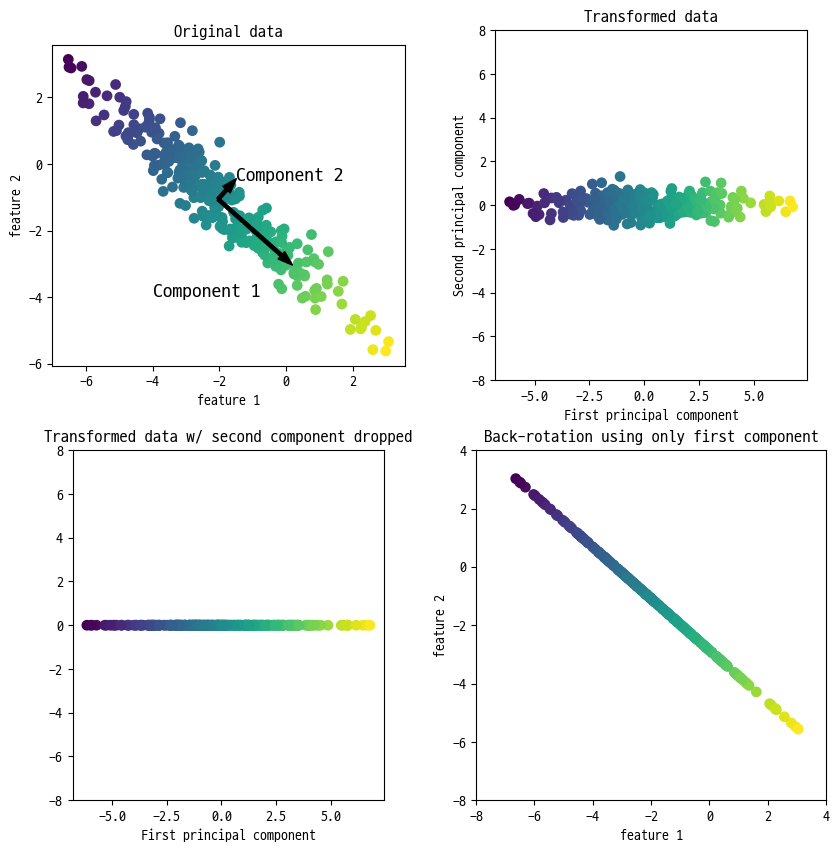

In [21]:
mglearn.plots.plot_pca_illustration()

## Base model과 비교

In [22]:
from sklearn.decomposition import PCA

주성분 숫자를 변경하지 않은 경우

In [23]:
pca = PCA(n_components=sparse_features.shape[1], random_state=SEED)
pca.fit(sparse_features)
sum(pca.explained_variance_ratio_)

1.000000000000022

In [24]:
tmp = pd.DataFrame(pca.transform(sparse_features)).add_prefix("pca_")
x_train = pd.concat([features, tmp], axis=1)
print(f"after: {x_train.shape}")

after: (891, 839)


In [25]:
model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model,x_train,y_train,cv = cv , scoring="roc_auc",n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8820825790187499 / base_score: 0.8766894920348889


주성분을 200으로 설정한 경우

In [31]:
pca200 = PCA(n_components=200, random_state=SEED)
pca200.fit(sparse_features)
# 주성분에 의해 설명되는 분산비율
sum(pca200.explained_variance_ratio_)

0.744494140840962

In [33]:
tmp = pd.DataFrame(pca200.transform(sparse_features)).add_prefix("pca_")
x_train = pd.concat([features, tmp], axis=1)
print(f"after: {x_train.shape}")

after: (891, 205)


In [36]:
model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model, x_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f'score: {scores.mean()} / base_score: {base_score}')

score: 0.8750590294915682 / base_score: 0.8766894920348889


주성분 400

In [37]:
pca400 = PCA(n_components=400, random_state=SEED)
pca400.fit(sparse_features)
sum(pca400.explained_variance_ratio_)

0.8514220959331706

In [38]:
tmp = pd.DataFrame(pca400.transform(sparse_features)).add_prefix("pca_")
x_train = pd.concat([features, tmp], axis=1)
print(f"after: {x_train.shape}")

after: (891, 405)


In [39]:
model = LGBMClassifier(random_state=SEED)
scores = cross_val_score(model, x_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)
print(f"score: {scores.mean()} / base_score: {base_score}")

score: 0.8876110031474249 / base_score: 0.8766894920348889


839개의 feature를 사용한 base_score보다 405개의 feature만 사용한 PCA가 score를 더 높게 받았다.